<a href="https://colab.research.google.com/github/utper/Capstone/blob/master/2-4-11-AssignmentQuestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bean Disease Classifier
For this assignment you'll take what you've learned so far and build a classifier for bean disease. You'll be provided with training and validation data based on 224x224 pixel color images taken of bean plants in Uganda. These images show healthy bean leaves as well as 2 types of common disease: bean rust and angular leaf spots. Your job will be to build a neural network that can tell the difference between the healthy and diseased leaves.

We start by setting up the problem for you.

In [11]:
# Do not change this code
# Verifica la versión de TensorFlow en Google Colab
# * Si el código se ejecuta en Google Colab, intenta cambiar la versión de TensorFlow a la 2.x.
# * Si la instrucción falla (por ejemplo, porque no está en Colab), el programa omite el error y continúa.
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [12]:
# Do not change this code
# Instala gdown
# * Instala la herramienta gdown, que permite descargar archivos desde Google Drive o Google Cloud Storage.
# * Usa --upgrade para asegurarse de tener la última versión.
# * Usa --no-cache-dir para evitar almacenar archivos en caché y forzar una descarga limpia.
!pip install --upgrade --no-cache-dir gdown

In [13]:
# Do not change this code
# Descarga los archivos de datos
# * Descarga tres archivos ZIP (train, validation y test) desde Google Cloud Storage.
# * Guarda los archivos en /tmp/, que es un directorio temporal en sistemas Linux y Colab.
!gdown "https://storage.googleapis.com/learning-datasets/beans/train.zip" -O /tmp/train.zip
!gdown "https://storage.googleapis.com/learning-datasets/beans/validation.zip" -O /tmp/validation.zip
!gdown "https://storage.googleapis.com/learning-datasets/beans/test.zip" -O /tmp/test.zip

Downloading...
From: https://storage.googleapis.com/learning-datasets/beans/train.zip
To: /tmp/train.zip
100% 144M/144M [00:00<00:00, 261MB/s]
Downloading...
From: https://storage.googleapis.com/learning-datasets/beans/validation.zip
To: /tmp/validation.zip
100% 18.5M/18.5M [00:00<00:00, 200MB/s]
Downloading...
From: https://storage.googleapis.com/learning-datasets/beans/test.zip
To: /tmp/test.zip
100% 17.7M/17.7M [00:00<00:00, 250MB/s]


In [14]:
# Do not change this code
import os
import zipfile

local_zip = '/tmp/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
local_zip = '/tmp/validation.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
local_zip = '/tmp/test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/test')
zip_ref.close()

Now you need to define a generator to process the data we have loaded in Colab so that our model can use it for training. As we showed in the previous video you'll first have to define an ```ImageDataGenerator``` and then flow the data into it.

*A hint: You don't want abnormal data!*

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Aumentación de imágenes en el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
      # YOUR CODE HERE #
      rescale=1./255,         # Normalización de los píxeles
      rotation_range=40,      # Rotación aleatoria hasta 40 grados
      width_shift_range=0.2,  # Desplazamiento horizontal
      height_shift_range=0.2, # Desplazamiento vertical
      shear_range=0.2,        # Deformaciones tipo cizalla
      zoom_range=0.2,         # Zoom aleatorio
      horizontal_flip=True,   # Inversión horizontal
      fill_mode='nearest'     # Se usa para manejar los píxeles vacíos que pueden aparecer cuando se aplican transformaciones como
                              # rotación, desplazamiento o cizallamiento.
)

# Solo normalización para el conjunto de validación
validation_datagen = ImageDataGenerator(
      # YOUR CODE HERE #
      rescale=1./255
)

# Directorios de los conjuntos de imágenes
# YOUR CODE HERE #
TRAIN_DIRECTORY_LOCATION = "/tmp/train"
VAL_DIRECTORY_LOCATION = "/tmp/validation"

# Tamaño de las imágenes y modo de clasificación
# YOUR CODE HERE #
TARGET_SIZE = (224, 224)    # Este valor define el tamaño al que se van a reescalar las imágenes antes de ingresarlas al modelo.
                            # * 224 × 224 píxeles es un tamaño estándar usado en modelos preentrenados como ResNet, MobileNet y VGG16.
                            # * Si tu modelo se basa en una red convolucional preentrenada, usar este tamaño ayuda a aprovechar mejor
                            #   los pesos preentrenados.
                            # * También estandariza el tamaño de entrada, permitiendo que el modelo trabaje con imágenes de dimensiones
                            #   uniformes.
                            # Si estuvieras usando un modelo diferente, podrías ajustar este tamaño según sus requisitos.
# Si quieres que el modelo diferencie entre hojas sanas, roya del frijol y manchas angulares, tendrías tres clases, y en ese caso
# class_mode="categorical" sería la opción correcta.
CLASS_MODE = "categorical"  # Define el tipo de salida que tendrá el generador de datos:
                            # * "categorical" se usa cuando tienes más de dos clases y necesitas que la salida sea un vector one-hot.
                            #   Por ejemplo, si tienes imágenes de tres categorías (maíz, frijoles, trigo), la salida podría ser
                            #   [1, 0, 0], [0, 1, 0], etc.
                            # * "binary" se usa cuando hay solo dos clases (ejemplo: "gato" y "perro"), devolviendo valores 0 o 1 en lugar
                            #   de un vector.
                            # * "sparse" es una alternativa a "categorical", donde las etiquetas son enteros en lugar de vectores one-hot.

# Generador de datos para entrenamiento
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIRECTORY_LOCATION,
    target_size = TARGET_SIZE,
    batch_size = 128,
    class_mode = CLASS_MODE
)

# Generador de datos para validación
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIRECTORY_LOCATION,
    target_size = TARGET_SIZE,
    batch_size = 128,
    class_mode = CLASS_MODE
)

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


Now its your turn to define a model to learn this data.

*A hint: Like with the CIFAR-10 assignment, your model may want to learn some high level features and then classify them. This time it may help to make the model a little wider at times.*

In [17]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    #YOUR CODE HERE#
    # Note the input shape is the desired size of the image 100x100 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# This will print a summary of your model when you're done!
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,675 (36.38 MB)

 Trainable params: 9,536,675 (36.38 MB)

 Non-trainable params: 0 (0.00 B)

Then you'll need to pick an appropriate loss function and optimizer.

*A hint: remember we are classifying again.*

In [19]:
#YOUR CODE HERE#
LOSS_FUNCTION = 'categorical_crossentropy'
OPTIMIZER = 'adam'

model.compile(
    loss = LOSS_FUNCTION,
    optimizer = OPTIMIZER,
    metrics = ['accuracy']
)

Finally select the number of epochs you'd like to train for and train your model!

*A hint: something in the low tens is a good place to start*

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.3458 - loss: 1.2175 - val_accuracy: 0.3308 - val_loss: 1.0727
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4050 - loss: 1.0797 - val_accuracy: 0.5564 - val_loss: 0.9933
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5478 - loss: 0.9953 - val_accuracy: 0.5113 - val_loss: 1.0001
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4880 - loss: 1.0837 - val_accuracy: 0.3910 - val_loss: 1.0626
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4261 - loss: 1.0744 - val_accuracy: 0.4812 - val_loss: 1.0126
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5154 - loss: 1.0095 - val_accuracy: 0.6617 - val_loss: 0.9550
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5970 - loss: 0.9420 - val_accuracy: 0.6541 - val_loss: 0.8478
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6191 - loss: 0.8507 - val_accuracy: 0.6767 - val_loss: 0.7794
Epoch 9/

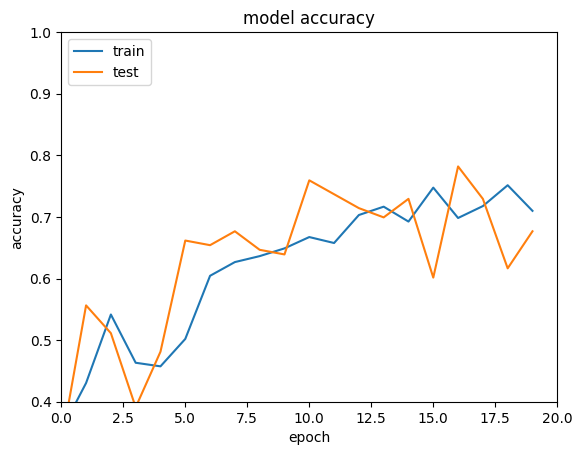

In [20]:
NUM_EPOCHS = 20 #YOUR CODE HERE#

history = model.fit(
      train_generator,
      epochs = NUM_EPOCHS,
      verbose = 1,
      validation_data = validation_generator)

# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xlim([0,NUM_EPOCHS])
plt.ylim([0.4,1.0])
plt.show()